In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)

devtools::load_all(".")

plan(multiprocess, workers = 25)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


In [2]:
sel_sims <-
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%.2f", seq(0.01, 0.1, 0.01)), function(admix_rate) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 50000))), function(admix_time) {
    future_map_dfr(1:25, function(rep) {

f <- here(glue("data/newsim/modern2neand_sel_chrY_seq{gene_total}_rate{admix_rate}_time{admix_time}_rep{rep}.txt"))
if (!file.exists(f)) return(NULL)

read_tsv(f, col_types = "idd") %>%
    mutate(admix_rate = admix_rate, gene_total = gene_total, admix_time = admix_time, rep = rep)

    })
    })
    })
    }) %>%
    mutate_all(as.numeric) %>%
    mutate(time = gen * 25) %>%
    select(-gen)

In [3]:
saveRDS(sel_sims, here("data/rds/sel_sims.rds"))

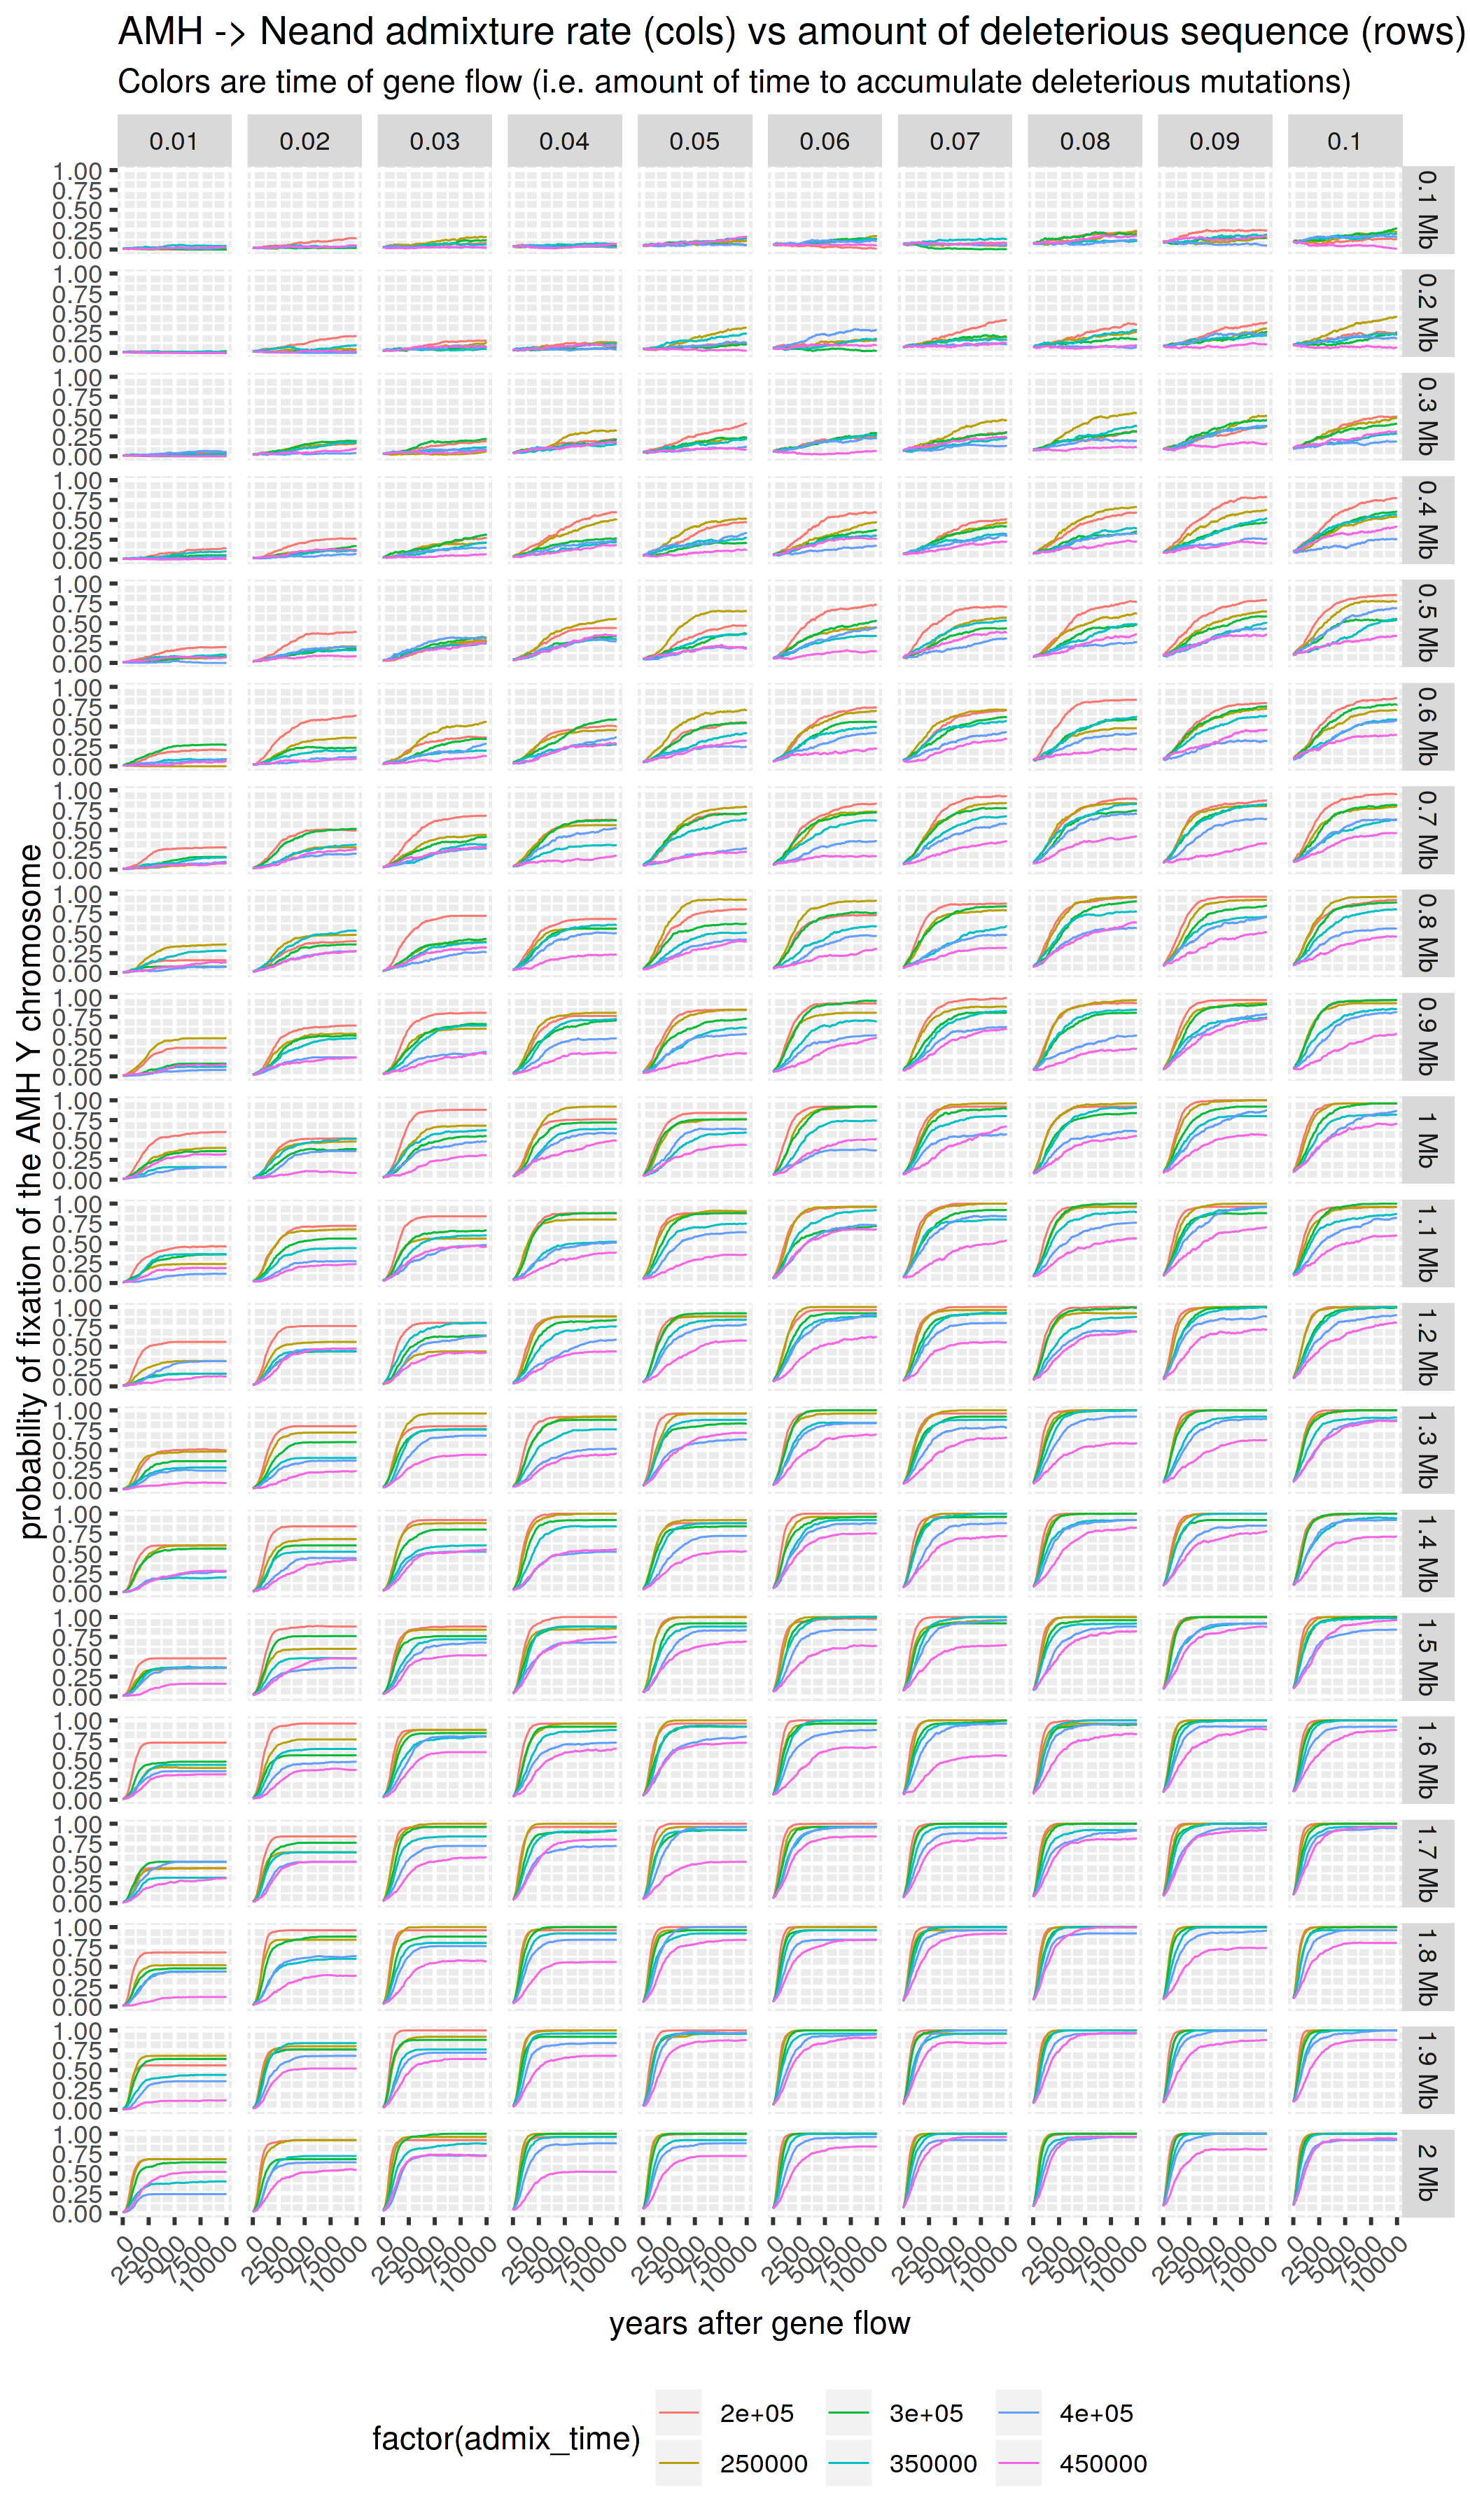

In [5]:
set_dim(7, 12)

sel_sims %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(time, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(neand), ~ mean(.x)) %>%
ggplot(aes(time, neand, color = factor(admix_time))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(gene_total ~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

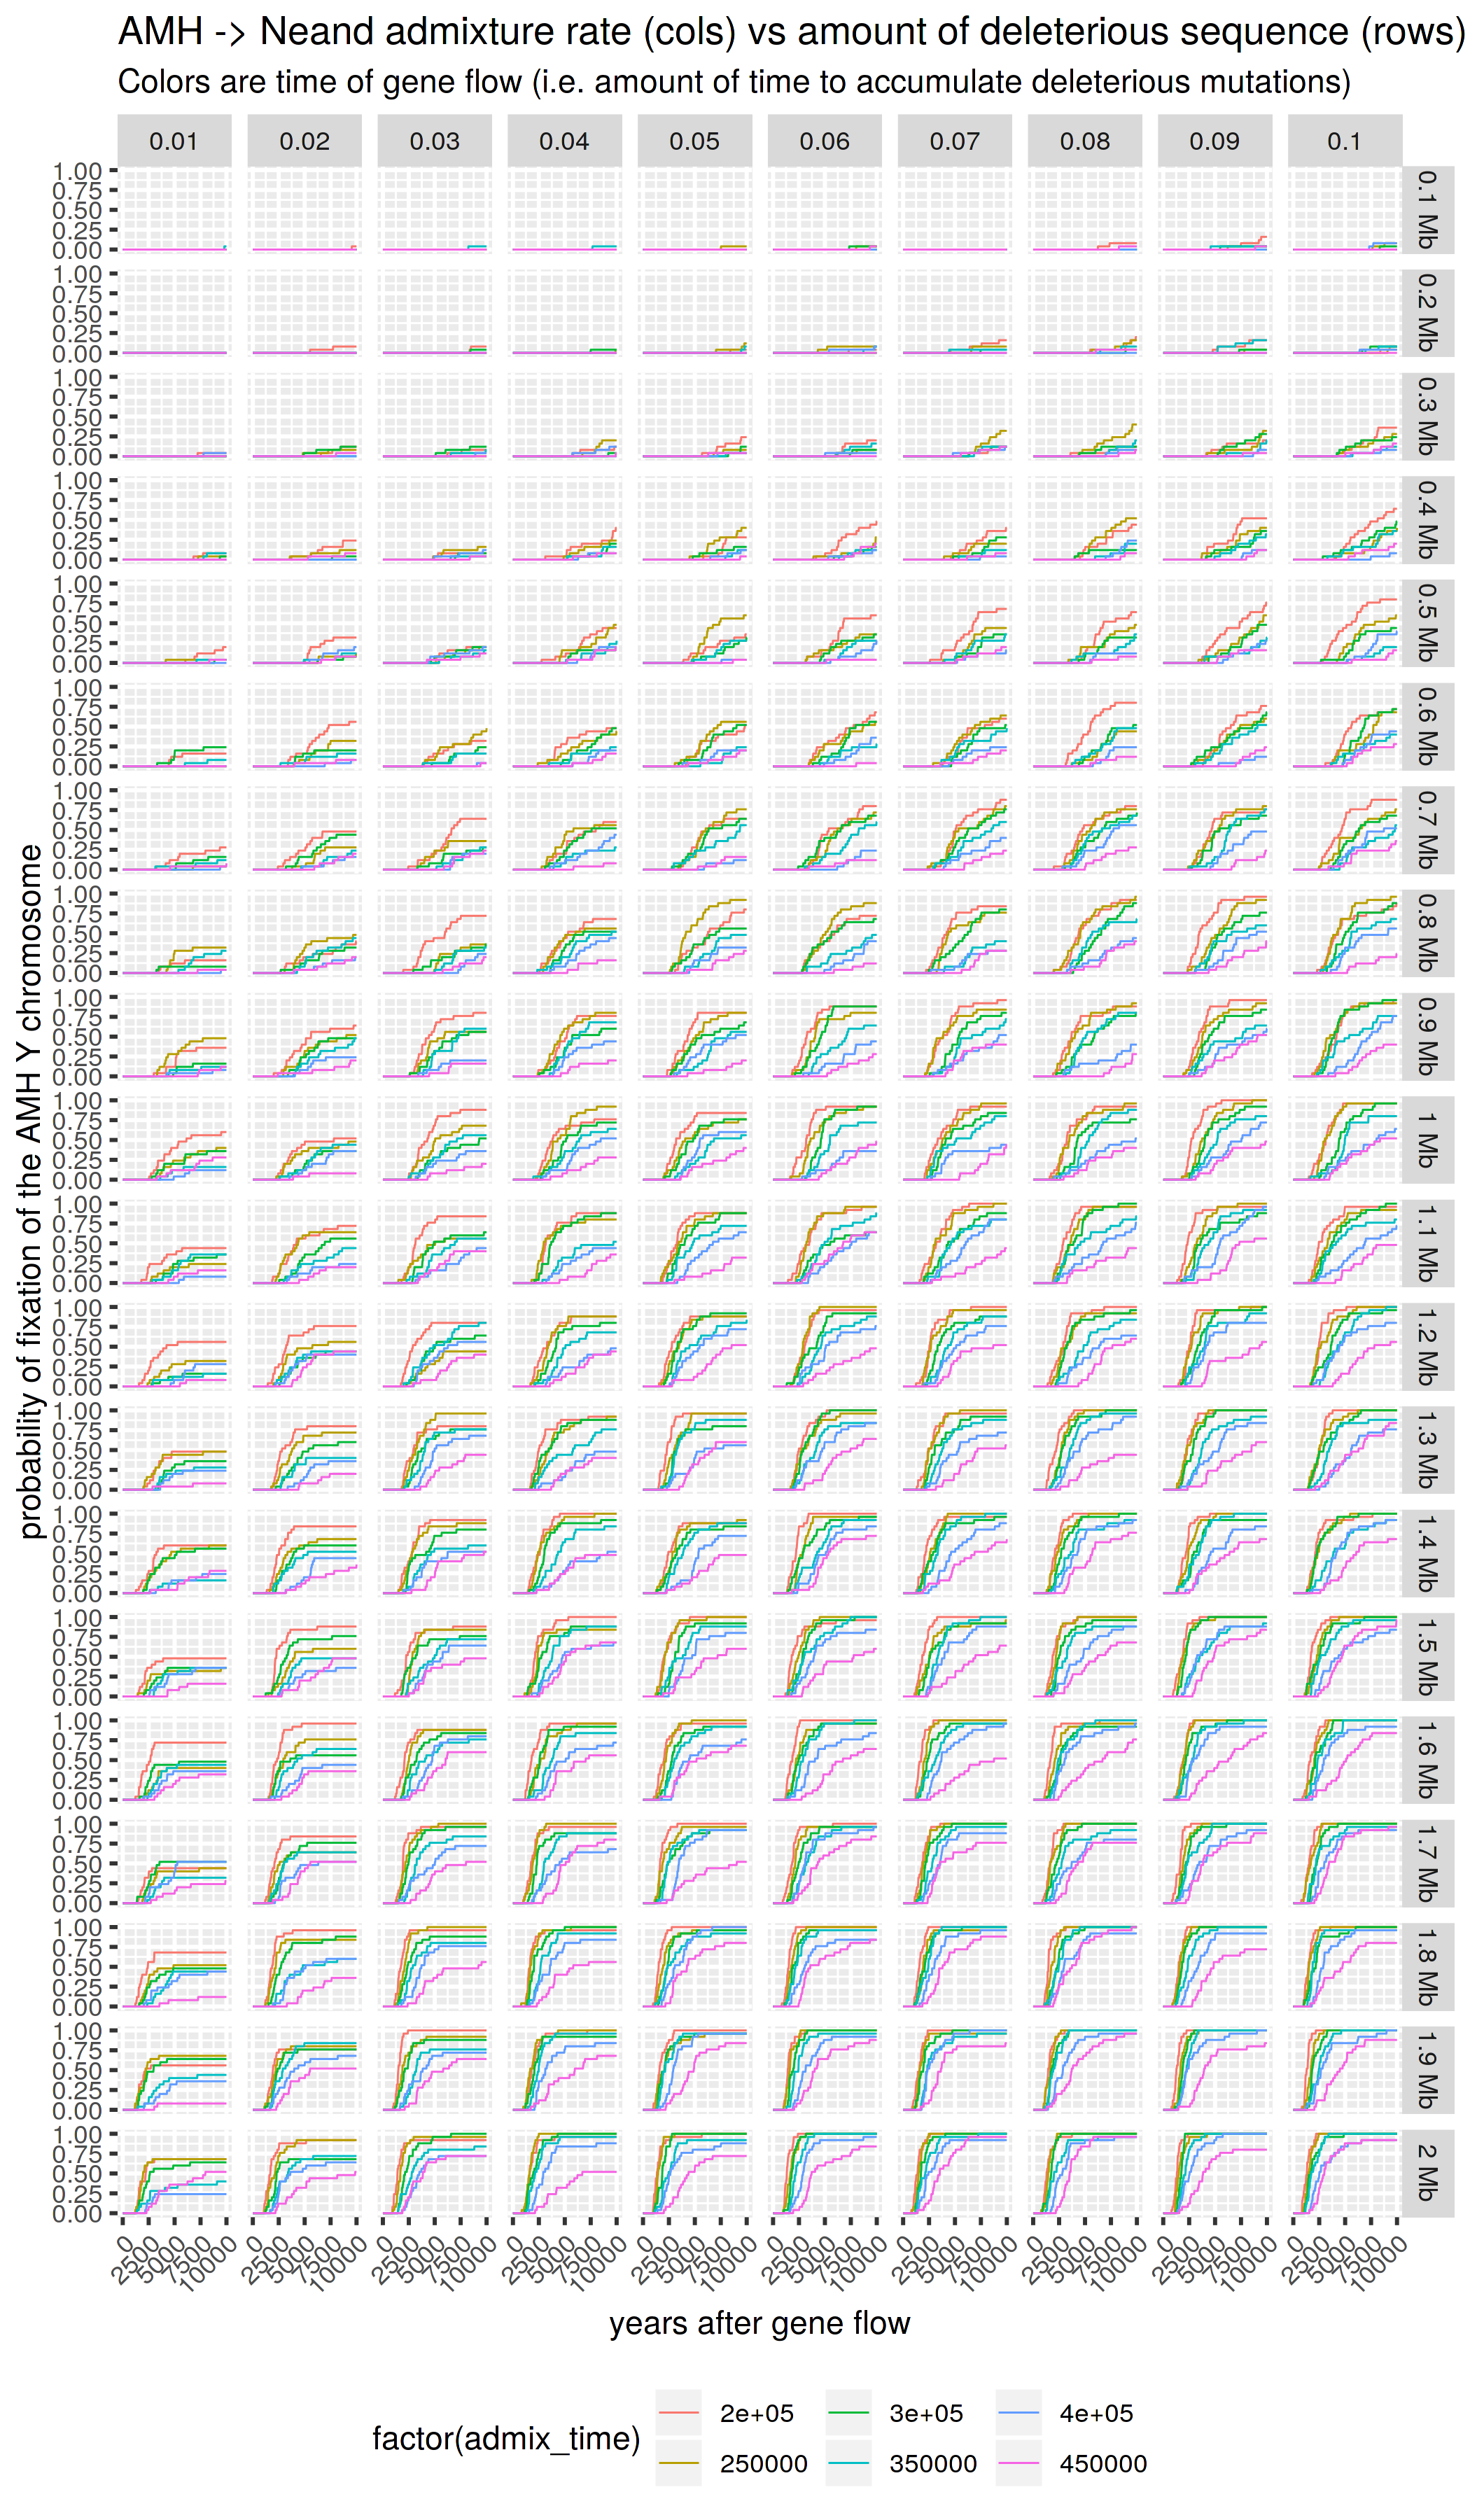

In [4]:
set_dim(7, 12)

sel_sims %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(time, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(neand), ~ mean(.x == 1)) %>%
ggplot(aes(time, neand, color = factor(admix_time))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(gene_total ~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [2]:
traj <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        f <- here(glue("data/sim/load/seq{gene_total}_time{admix_time}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep)

    })
    })
    }) %>%
    mutate_all(as.numeric)

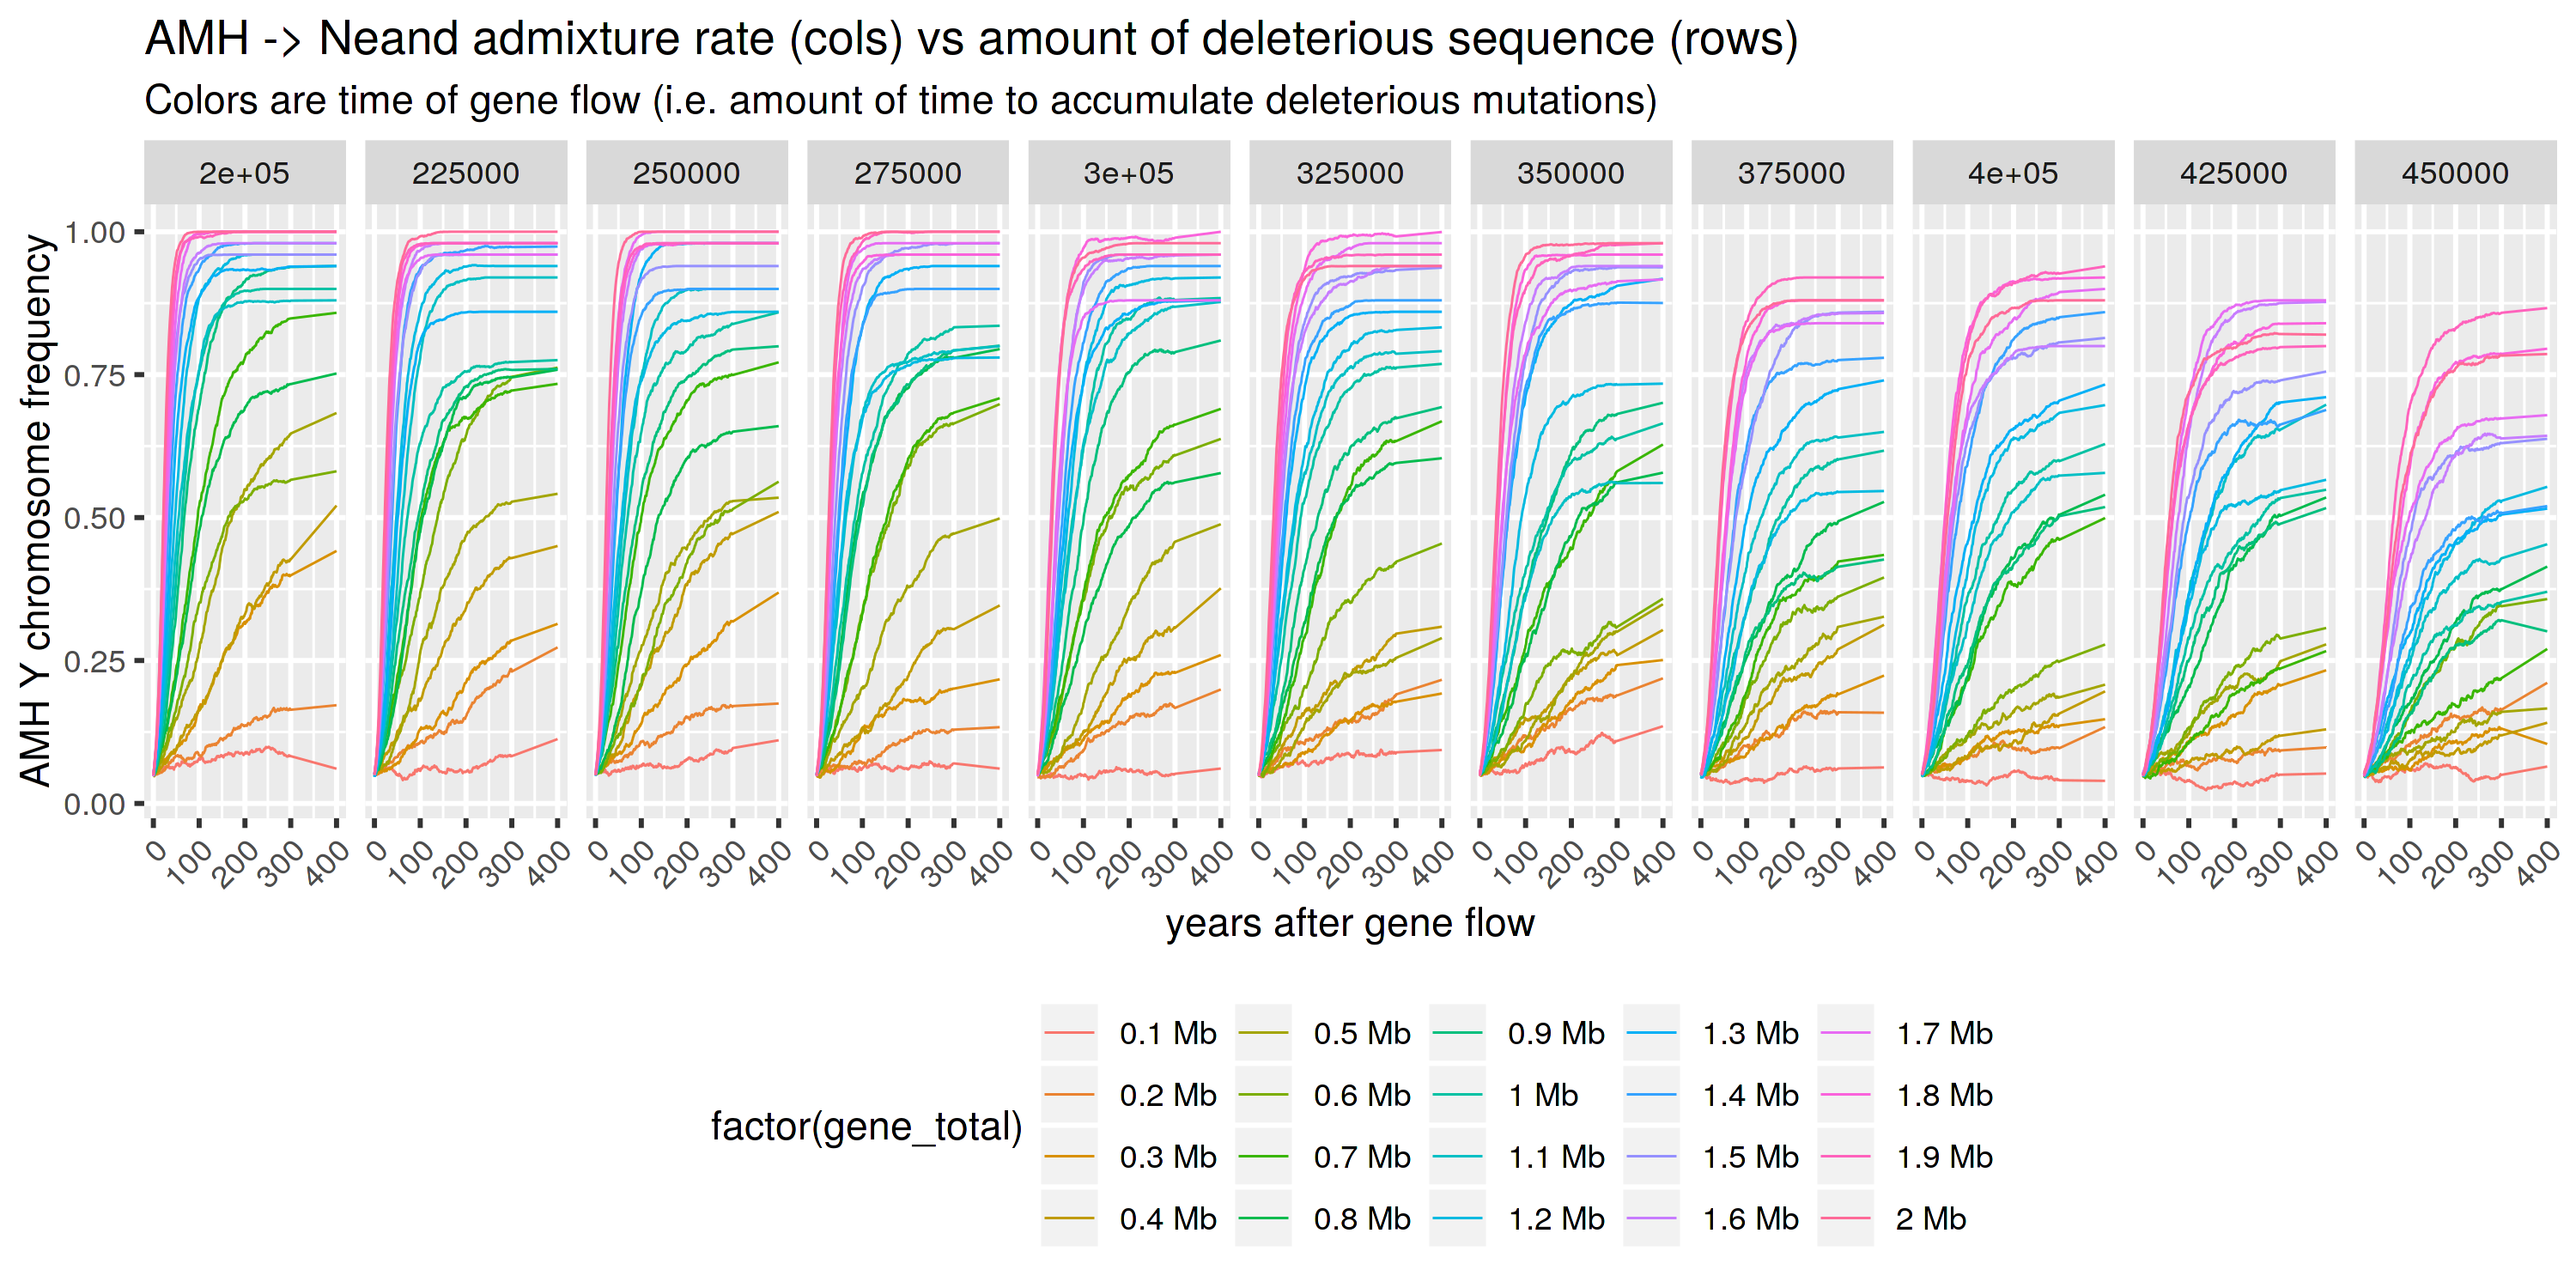

In [3]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(ancestry), ~ mean(.x)) %>%
ggplot(aes(gen, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

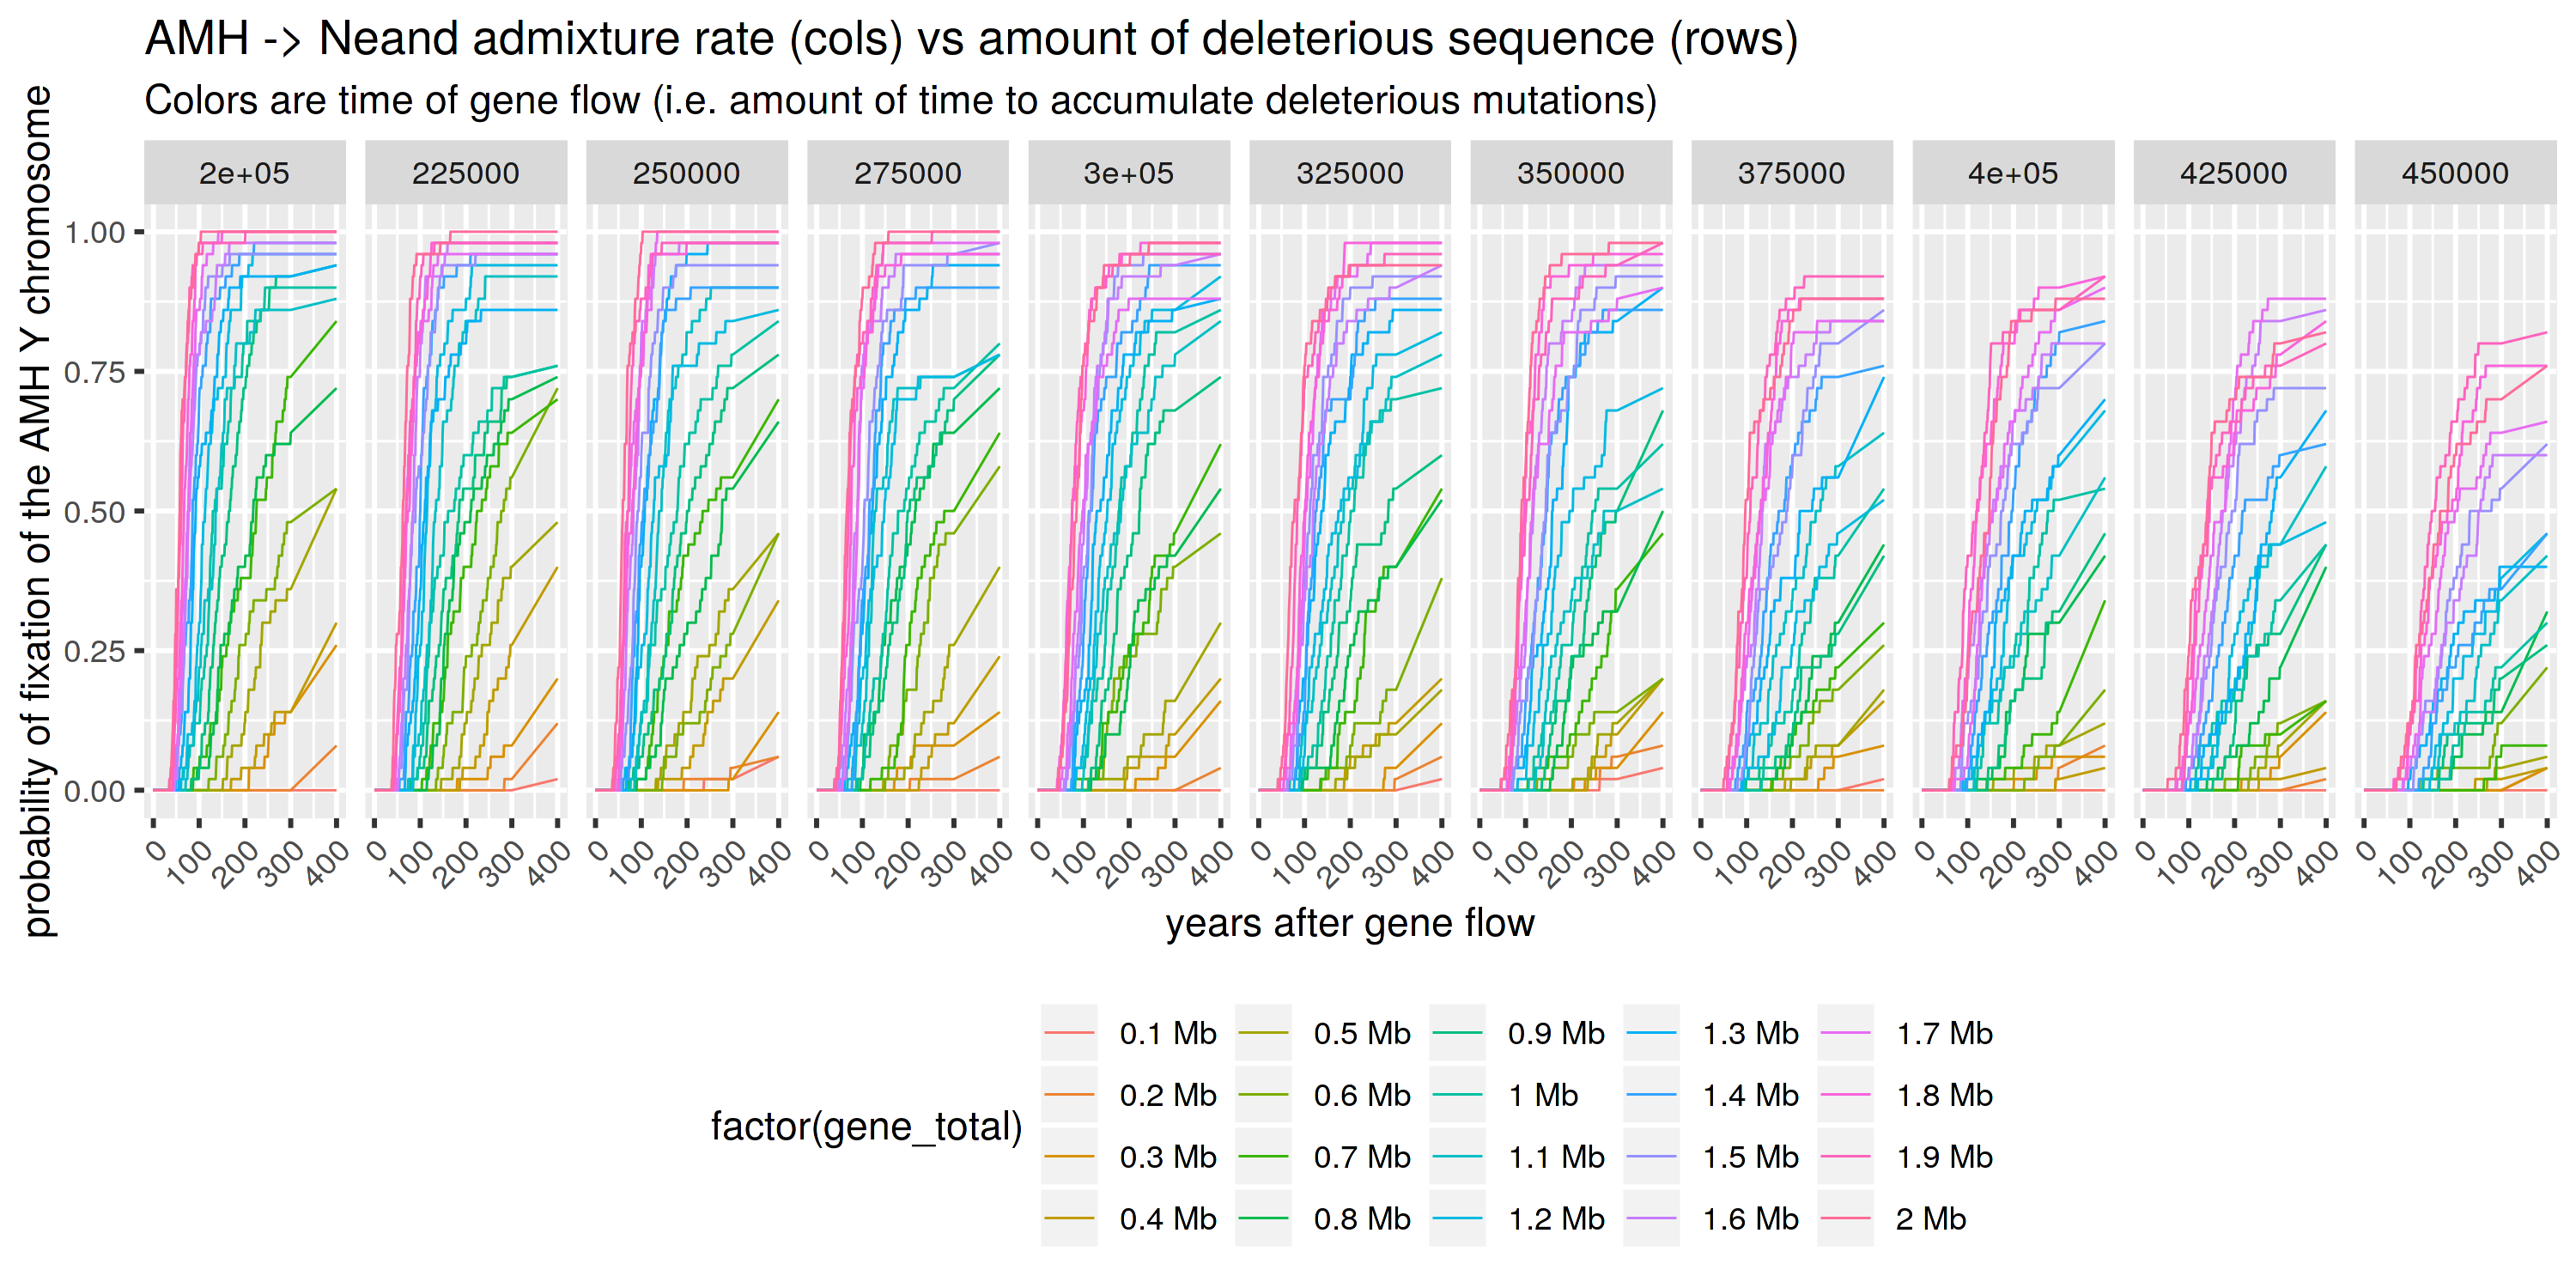

In [4]:
set_dim(10, 5)

traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(ancestry), ~ mean(.x == 1)) %>%
ggplot(aes(gen, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [2]:
load <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        f <- here(glue("data/sim/load/seq{gene_total}_time{admix_time}_rep{rep}_pop.txt.gz"))

        loads <- read_slim(f) %>%
            calculate_load %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep)

    })
    })
    })

In [3]:
saveRDS(load, "../data/rds/loads.rds")

In [9]:
mean_load <- load %>%
    group_by(genome_id, pop, admix_rate, gene_total, admix_time) %>%
    summarise_all(mean) %>%
    mutate(case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))

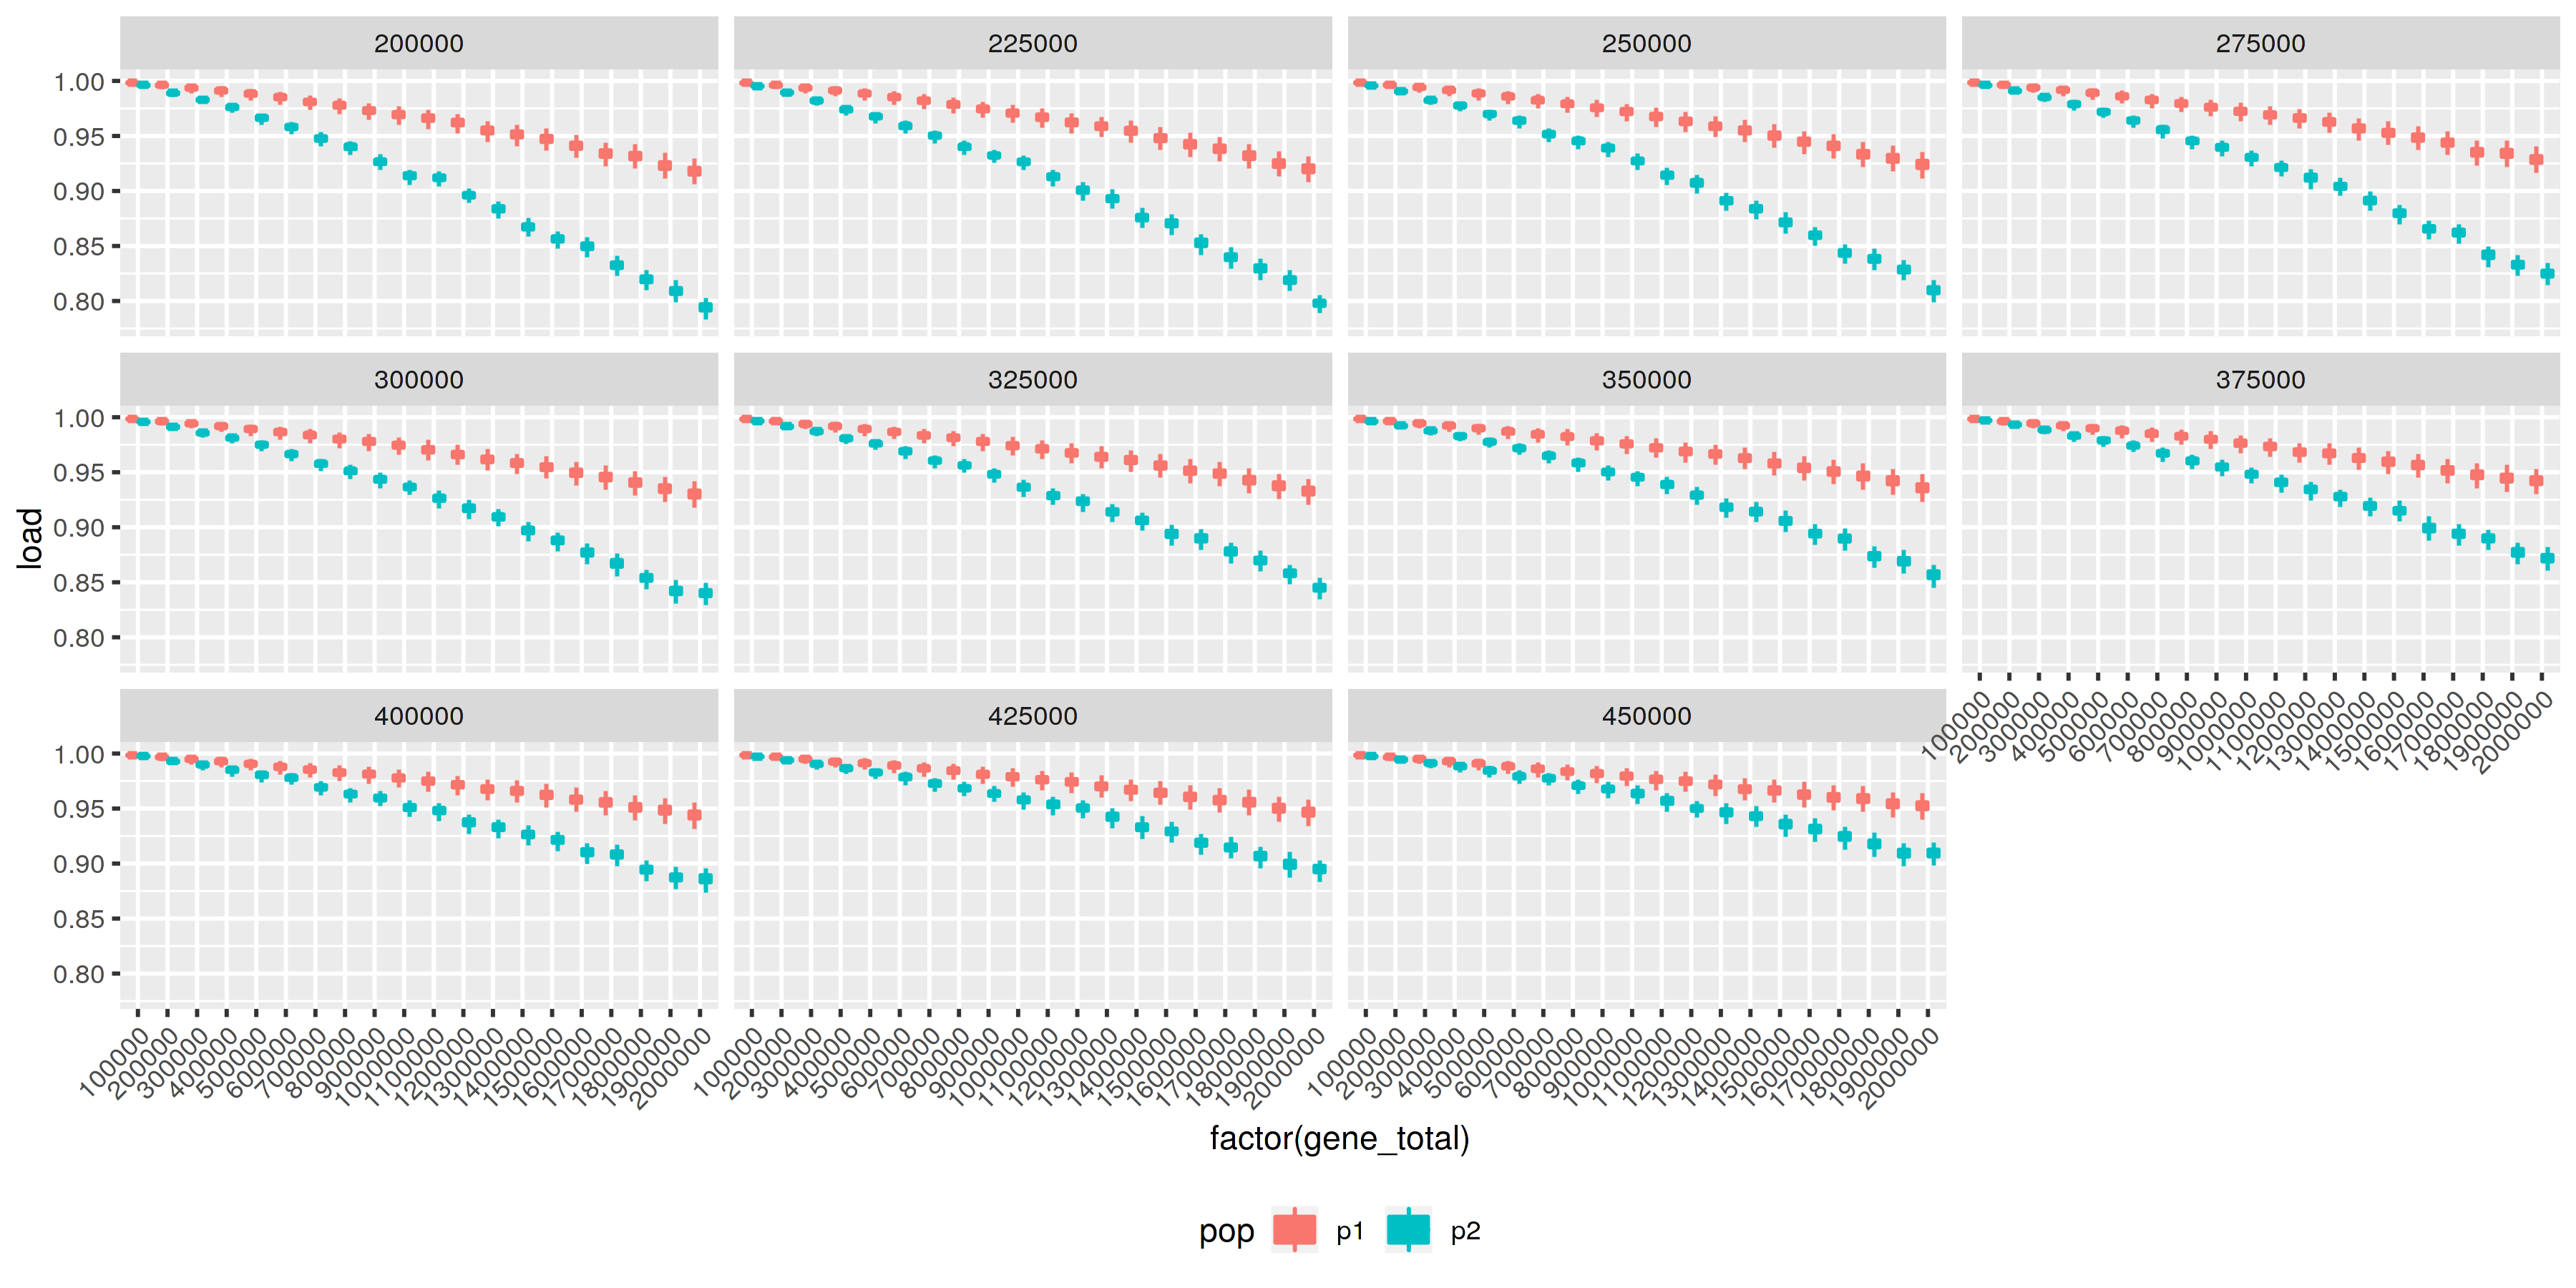

In [16]:
set_dim(12, 6)

mean_load %>%
ggplot(aes(factor(gene_total), load, fill = pop, color = pop)) +
    geom_boxplot(outlier.shape = NA) +
    facet_wrap(~ admix_time) +
    theme(legend.position = "bottom",
          axis.text.x = element_text(hjust = 1, angle = 45))

amount of sequence vs time after split trade-off:

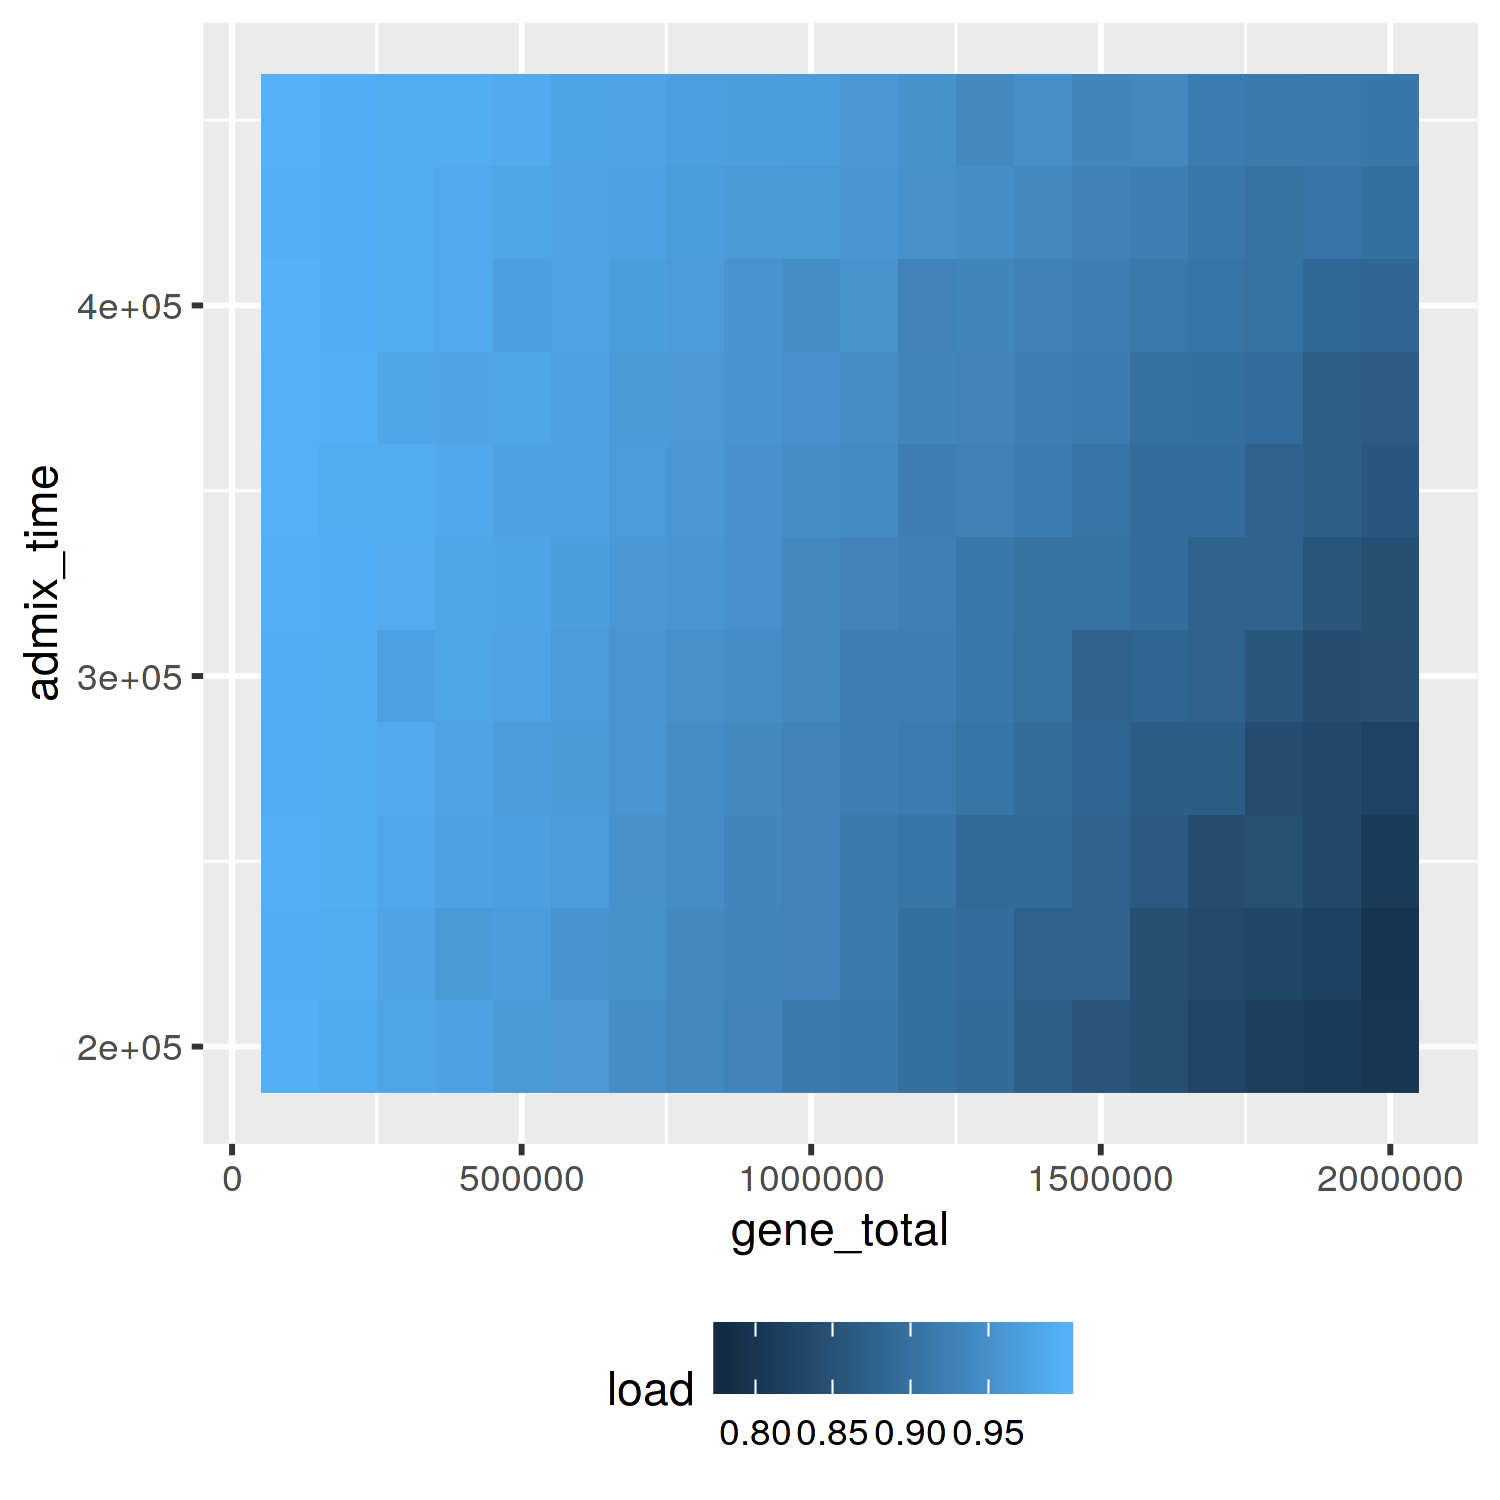

In [19]:
set_dim(5, 5)

mean_loads %>%
filter(pop == "p2") %>%
ggplot(aes(gene_total, admix_time)) +
    geom_raster(aes(fill = load)) +
    theme(legend.position = "bottom")

In [32]:
traj_load <-
    future_map_dfr(1:50, function(rep) {
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 25000))), function(admix_time) {

        path <- here(glue("data/sim/load/seq{gene_total}_time{admix_time}_rep{rep}"))

        f <- paste0(path, "_pop.txt.gz") %>% read_slim

        load_modern <- calculate_load(f, "p1")
        load_neand <- calculate_load(f, "p2")

        paste0(path, "_traj.tsv") %>%
            read_tsv(col_types = "id") %>%
            mutate(admix_rate = 0.05,
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   rep = rep,
                   load_modern = mean(load_modern$load),
                   load_neand = mean(load_neand$load),
                   ratio = load_neand / load_modern)

    })
    })
    })

In [24]:
mean_traj_load <- traj_load %>%
    group_by(gen, admix_rate, gene_total, admix_time) %>%
    summarise_all(mean)

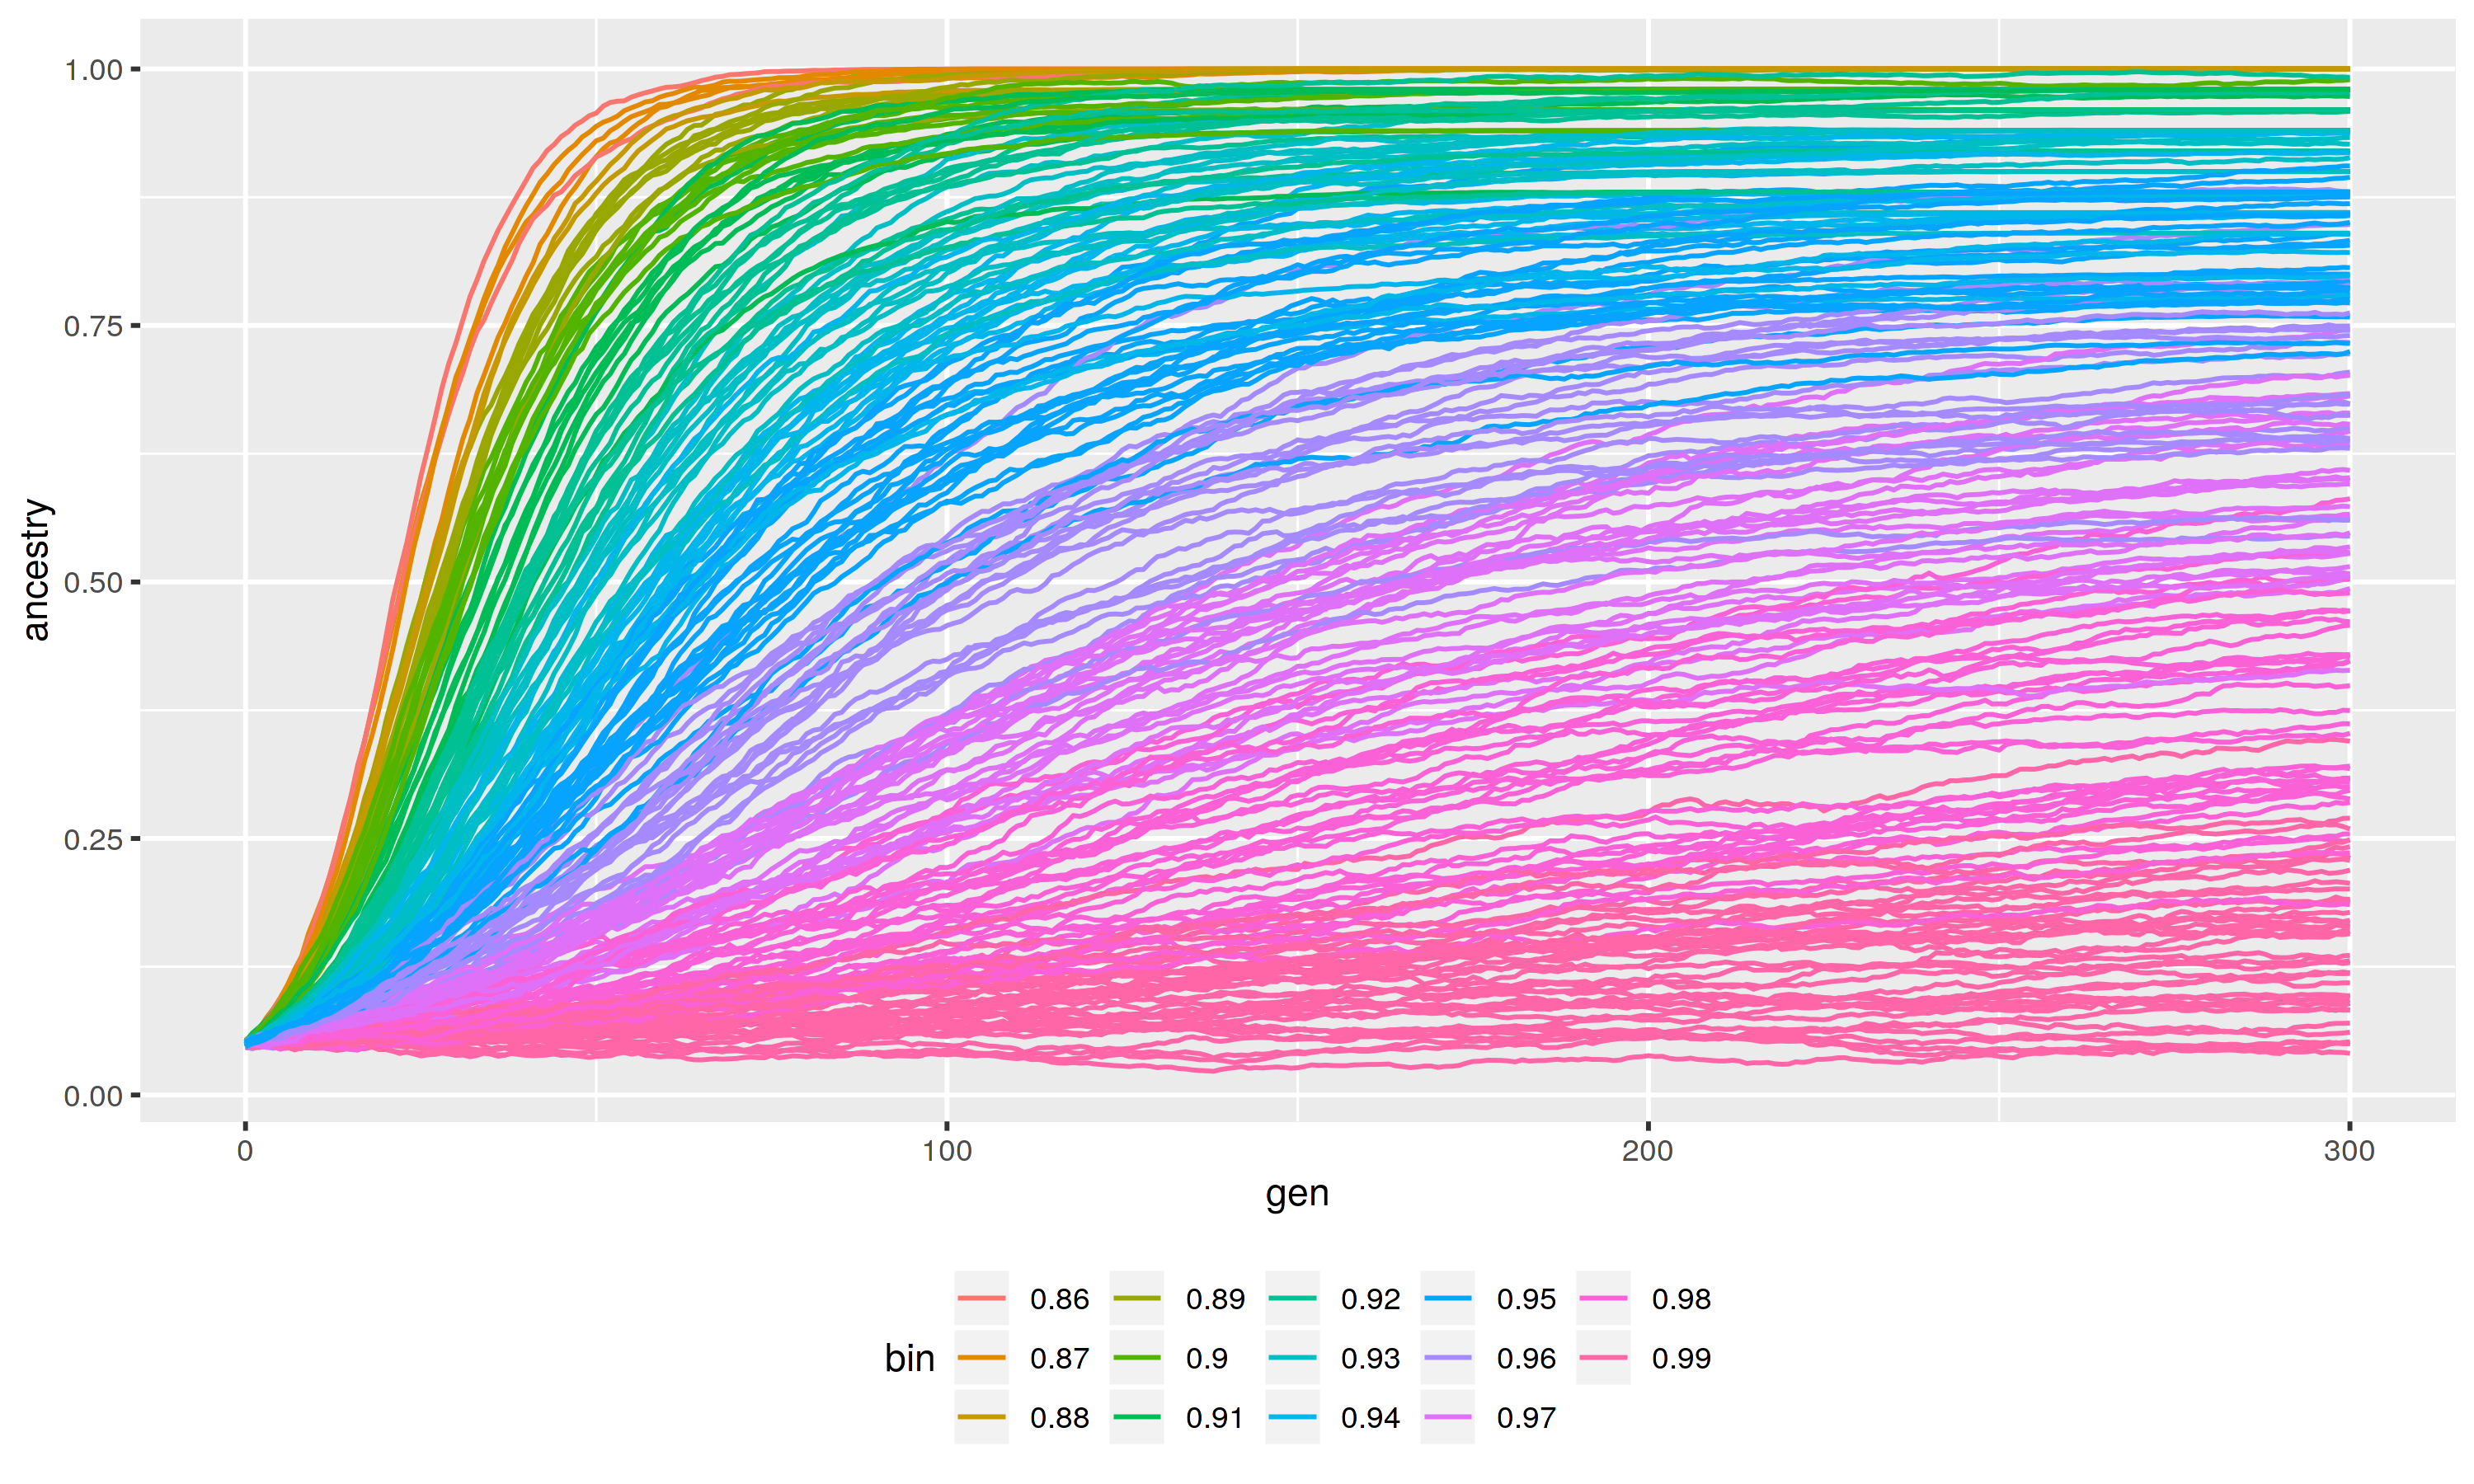

In [41]:
set_dim(10, 6)

mean_traj_load %>%
filter(gen < 400) %>%
mutate(bin = cut(ratio, seq(0.8, 1.01, 0.01), labels = seq(0.81, 1.01, 0.01) - 0.01)) %>%
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme(legend.position = "bottom")

In [39]:
prob_traj_load <- traj_load %>%
    group_by(gen, admix_rate, gene_total, admix_time, load_modern, load_neand, ratio) %>%
    summarise_at(vars(ancestry), ~ mean(.x == 1))

In [ ]:
set_dim(10, 6)

prob_traj_load %>%
filter(gen < 100) %>%
mutate(bin = cut(ratio, seq(0.8, 1.01, 0.01), labels = seq(0.81, 1.01, 0.01) - 0.01)) %>%
ggplot(aes(gen, ancestry, color = bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme(legend.position = "bottom")